In [15]:
import matplotlib as mpl
import matplotlib.pyplot as plt
def plotBinary(binaryGrid):
    """
    1 is black
    0 is red
    """
    # https://stackoverflow.com/questions/28517400/matplotlib-binary-heat-plot
    fig, ax = plt.subplots()

    plt.grid(axis='both')
    # define the colors
    cmap = mpl.colors.ListedColormap(['k', 'r'])

    # create a normalize object the describes the limits of
    # each color
    bounds = [0., 0.5, 1.]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    # plot it
    ax.imshow(binaryGrid, interpolation='none', cmap=cmap, norm=norm)

In [70]:
"""
Cubic spline planner

Author: Atsushi Sakai(@Atsushi_twi)
https://github.com/AtsushiSakai/PythonRobotics/blob/53eae53b5a78a08b7ce4c6ffeed727c1d6a0ab2e/PathPlanning/CubicSpline/cubic_spline_planner.py#L311
"""
import math
import numpy as np
import bisect

class CubicSpline1D:
    """
    1D Cubic Spline class

    Parameters
    ----------
    x : list
        x coordinates for data points. This x coordinates must be
        sorted
        in ascending order.
    y : list
        y coordinates for data points

    Examples
    --------
    You can interpolate 1D data points.

    >>> import numpy as np
    >>> import matplotlib.pyplot as plt
    >>> x = np.arange(5)
    >>> y = [1.7, -6, 5, 6.5, 0.0]
    >>> sp = CubicSpline1D(x, y)
    >>> xi = np.linspace(0.0, 5.0)
    >>> yi = [sp.calc_position(x) for x in xi]
    >>> plt.plot(x, y, "xb", label="Data points")
    >>> plt.plot(xi, yi , "r", label="Cubic spline interpolation")
    >>> plt.grid(True)
    >>> plt.legend()
    >>> plt.show()

    .. image:: cubic_spline_1d.png

    """

    def __init__(self, x, y):

        h = np.diff(x)
        if np.any(h < 0):
            raise ValueError("x coordinates must be sorted in ascending order")

        self.a, self.b, self.c, self.d = [], [], [], []
        self.x = x
        self.y = y
        self.nx = len(x)  # dimension of x

        # calc coefficient a
        self.a = [iy for iy in y]

        # calc coefficient c
        A = self.__calc_A(h)
        B = self.__calc_B(h, self.a)
        self.c = np.linalg.solve(A, B)

        # calc spline coefficient b and d
        for i in range(self.nx - 1):
            d = (self.c[i + 1] - self.c[i]) / (3.0 * h[i])
            b = 1.0 / h[i] * (self.a[i + 1] - self.a[i]) \
                - h[i] / 3.0 * (2.0 * self.c[i] + self.c[i + 1])
            self.d.append(d)
            self.b.append(b)

    def calc_position(self, x):
        """
        Calc `y` position for given `x`.

        if `x` is outside the data point's `x` range, return None.

        Returns
        -------
        y : float
            y position for given x.
        """
        if x < self.x[0]:
            return None
        elif x > self.x[-1]:
            return None

        i = self.__search_index(x)
        dx = x - self.x[i]
        position = self.a[i] + self.b[i] * dx + \
            self.c[i] * dx ** 2.0 + self.d[i] * dx ** 3.0

        return position

    def calc_first_derivative(self, x):
        """
        Calc first derivative at given x.

        if x is outside the input x, return None

        Returns
        -------
        dy : float
            first derivative for given x.
        """

        if x < self.x[0]:
            return None
        elif x > self.x[-1]:
            return None

        i = self.__search_index(x)
        dx = x - self.x[i]
        dy = self.b[i] + 2.0 * self.c[i] * dx + 3.0 * self.d[i] * dx ** 2.0
        return dy

    def calc_second_derivative(self, x):
        """
        Calc second derivative at given x.

        if x is outside the input x, return None

        Returns
        -------
        ddy : float
            second derivative for given x.
        """

        if x < self.x[0]:
            return None
        elif x > self.x[-1]:
            return None

        i = self.__search_index(x)
        dx = x - self.x[i]
        ddy = 2.0 * self.c[i] + 6.0 * self.d[i] * dx
        return ddy

    def __search_index(self, x):
        """
        search data segment index
        """
        return bisect.bisect(self.x, x) - 1

    def __calc_A(self, h):
        """
        calc matrix A for spline coefficient c
        """
        A = np.zeros((self.nx, self.nx))
        A[0, 0] = 1.0
        for i in range(self.nx - 1):
            if i != (self.nx - 2):
                A[i + 1, i + 1] = 2.0 * (h[i] + h[i + 1])
            A[i + 1, i] = h[i]
            A[i, i + 1] = h[i]

        A[0, 1] = 0.0
        A[self.nx - 1, self.nx - 2] = 0.0
        A[self.nx - 1, self.nx - 1] = 1.0
        return A

    def __calc_B(self, h, a):
        """
        calc matrix B for spline coefficient c
        """
        B = np.zeros(self.nx)
        for i in range(self.nx - 2):
            B[i + 1] = 3.0 * (a[i + 2] - a[i + 1]) / h[i + 1]\
                - 3.0 * (a[i + 1] - a[i]) / h[i]
        return B

class CubicSpline2D:
    """
    Cubic CubicSpline2D class

    Parameters
    ----------
    x : list
        x coordinates for data points.
    y : list
        y coordinates for data points.

    Examples
    --------
    You can interpolate a 2D data points.

    >>> import matplotlib.pyplot as plt
    >>> x = [-2.5, 0.0, 2.5, 5.0, 7.5, 3.0, -1.0]
    >>> y = [0.7, -6, 5, 6.5, 0.0, 5.0, -2.0]
    >>> ds = 0.1  # [m] distance of each interpolated points
    >>> sp = CubicSpline2D(x, y)
    >>> s = np.arange(0, sp.s[-1], ds)
    >>> rx, ry, ryaw, rk = [], [], [], []
    >>> for i_s in s:
    ...     ix, iy = sp.calc_position(i_s)
    ...     rx.append(ix)
    ...     ry.append(iy)
    ...     ryaw.append(sp.calc_yaw(i_s))
    ...     rk.append(sp.calc_curvature(i_s))
    >>> plt.subplots(1)
    >>> plt.plot(x, y, "xb", label="Data points")
    >>> plt.plot(rx, ry, "-r", label="Cubic spline path")
    >>> plt.grid(True)
    >>> plt.axis("equal")
    >>> plt.xlabel("x[m]")
    >>> plt.ylabel("y[m]")
    >>> plt.legend()
    >>> plt.show()

    .. image:: cubic_spline_2d_path.png

    >>> plt.subplots(1)
    >>> plt.plot(s, [np.rad2deg(iyaw) for iyaw in ryaw], "-r", label="yaw")
    >>> plt.grid(True)
    >>> plt.legend()
    >>> plt.xlabel("line length[m]")
    >>> plt.ylabel("yaw angle[deg]")

    .. image:: cubic_spline_2d_yaw.png

    >>> plt.subplots(1)
    >>> plt.plot(s, rk, "-r", label="curvature")
    >>> plt.grid(True)
    >>> plt.legend()
    >>> plt.xlabel("line length[m]")
    >>> plt.ylabel("curvature [1/m]")

    .. image:: cubic_spline_2d_curvature.png
    """

    def __init__(self, x, y):
        self.s = self.__calc_s(x, y)
        self.sx = CubicSpline1D(self.s, x)
        self.sy = CubicSpline1D(self.s, y)

    def __calc_s(self, x, y):
        dx = np.diff(x)
        dy = np.diff(y)
        self.ds = np.hypot(dx, dy)
        s = [0]
        s.extend(np.cumsum(self.ds))
        return s

    def calc_position(self, s):
        """
        calc position

        Parameters
        ----------
        s : float
            distance from the start point. if `s` is outside the data point's
            range, return None.

        Returns
        -------
        x : float
            x position for given s.
        y : float
            y position for given s.
        """
        x = self.sx.calc_position(s)
        y = self.sy.calc_position(s)

        return x, y

    def calc_curvature(self, s):
        """
        calc curvature

        Parameters
        ----------
        s : float
            distance from the start point. if `s` is outside the data point's
            range, return None.

        Returns
        -------
        k : float
            curvature for given s.
        """
        dx = self.sx.calc_first_derivative(s)
        ddx = self.sx.calc_second_derivative(s)
        dy = self.sy.calc_first_derivative(s)
        ddy = self.sy.calc_second_derivative(s)
        k = (ddy * dx - ddx * dy) / ((dx ** 2 + dy ** 2)**(3 / 2))
        return k

    def calc_yaw(self, s):
        """
        calc yaw

        Parameters
        ----------
        s : float
            distance from the start point. if `s` is outside the data point's
            range, return None.

        Returns
        -------
        yaw : float
            yaw angle (tangent vector) for given s.
        """
        dx = self.sx.calc_first_derivative(s)
        dy = self.sy.calc_first_derivative(s)
        yaw = math.atan2(dy, dx)
        return yaw


def calculateSpline2d(path, cell_size=1.0):
    x,y = zip(*path)
    sp = CubicSpline2D(x, y)
    s = np.arange(0, sp.s[-1], cell_size)
    
    rx, ry, ryaw, rk = [], [], [], []
    for i_s in s:
        ix, iy = sp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
        ryaw.append(sp.calc_yaw(i_s))
        rk.append(sp.calc_curvature(i_s))

    return zip(rx,ry)

def main_2d():  # pragma: no cover
    print("CubicSpline1D 2D test")
    import matplotlib.pyplot as plt
    x = [-2.5, 0.0, 2.5, 5.0, 7.5, 3.0, -1.0]
    y = [0.7, -6, 5, 6.5, 0.0, 5.0, -2.0]
    ds = 0.1  # [m] distance of each interpolated points

    sp = CubicSpline2D(x, y)
    s = np.arange(0, sp.s[-1], ds)

    rx, ry, ryaw, rk = [], [], [], []
    for i_s in s:
        ix, iy = sp.calc_position(i_s)
        rx.append(ix)
        ry.append(iy)
        ryaw.append(sp.calc_yaw(i_s))
        rk.append(sp.calc_curvature(i_s))

    # plt.subplots(1)
    # plt.plot(x, y, "xb", label="Data points")
    # plt.plot(rx, ry, "-r", label="Cubic spline path")
    # plt.grid(True)
    # plt.axis("equal")
    # plt.xlabel("x[m]")
    # plt.ylabel("y[m]")
    # plt.legend()

    # plt.subplots(1)
    # plt.plot(s, [np.rad2deg(iyaw) for iyaw in ryaw], "-r", label="yaw")
    # plt.grid(True)
    # plt.legend()
    # plt.xlabel("line length[m]")
    # plt.ylabel("yaw angle[deg]")

    # plt.subplots(1)
    # plt.plot(s, rk, "-r", label="curvature")
    # plt.grid(True)
    # plt.legend()
    # plt.xlabel("line length[m]")
    # plt.ylabel("curvature [1/m]")

    # plt.show()

main_2d()

CubicSpline1D 2D test


In [3]:
"""
Distance/Path Transform Wavefront Coverage Path Planner

author: Todd Tang
paper: Planning paths of complete coverage of an unstructured environment
         by a mobile robot - Zelinsky et.al.
link: http://pinkwink.kr/attachment/cfile3.uf@1354654A4E8945BD13FE77.pdf

https://github.com/AtsushiSakai/PythonRobotics/blob/master/PathPlanning/WavefrontCPP/wavefront_coverage_path_planner.py
"""

import sys

import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage

# set to false when running in jupyter notebook
# set to true when running from CLI to see path animation
do_animation = False


def wavefront_transform(
        grid_map, src, distance_type='chessboard',
        transform_type='path', alpha=0.01
):
    """transform

    calculating transform of transform_type from src
    in given distance_type

    :param grid_map: 2d binary map
    :param src: distance transform source
    :param distance_type: type of distance used
    :param transform_type: type of transform used
    :param alpha: weight of Obstacle Transform used when using path_transform
    """

    n_rows, n_cols = grid_map.shape

    if n_rows == 0 or n_cols == 0:
        sys.exit('Empty grid_map.')

    inc_order = [[0, 1], [1, 1], [1, 0], [1, -1],
                 [0, -1], [-1, -1], [-1, 0], [-1, 1]]
    if distance_type == 'chessboard':
        cost = [1, 1, 1, 1, 1, 1, 1, 1]
    elif distance_type == 'eculidean':
        cost = [1, np.sqrt(2), 1, np.sqrt(2), 1, np.sqrt(2), 1, np.sqrt(2)]
    else:
        sys.exit('Unsupported distance type.')

    transform_matrix = float('inf') * np.ones_like(grid_map, dtype=float)
    transform_matrix[src[0], src[1]] = 0
    if transform_type == 'distance':
        eT = np.zeros_like(grid_map)
    elif transform_type == 'path':
        eT = ndimage.distance_transform_cdt(1 - grid_map, distance_type)
    else:
        sys.exit('Unsupported transform type.')

    # set obstacle transform_matrix value to infinity
    for i in range(n_rows):
        for j in range(n_cols):
            if grid_map[i][j] == 1.0:
                transform_matrix[i][j] = float('inf')
    is_visited = np.zeros_like(transform_matrix, dtype=bool)
    is_visited[src[0], src[1]] = True
    traversal_queue = [src]
    calculated = [(src[0] - 1) * n_cols + src[1]]

    def is_valid_neighbor(g_i, g_j):
        return 0 <= g_i < n_rows and 0 <= g_j < n_cols \
               and not grid_map[g_i][g_j]

    while traversal_queue:
        i, j = traversal_queue.pop(0)
        for k, inc in enumerate(inc_order):
            ni = i + inc[0]
            nj = j + inc[1]
            if is_valid_neighbor(ni, nj):
                is_visited[i][j] = True

                # update transform_matrix
                transform_matrix[i][j] = min(
                    transform_matrix[i][j],
                    transform_matrix[ni][nj] + cost[k] + alpha * eT[ni][nj])

                if not is_visited[ni][nj] \
                        and ((ni - 1) * n_cols + nj) not in calculated:
                    traversal_queue.append((ni, nj))
                    calculated.append((ni - 1) * n_cols + nj)

    return transform_matrix


def get_search_order_increment(start, goal):
    if start[0] >= goal[0] and start[1] >= goal[1]:
        order = [[1, 0], [0, 1], [-1, 0], [0, -1],
                 [1, 1], [1, -1], [-1, 1], [-1, -1]]
    elif start[0] <= goal[0] and start[1] >= goal[1]:
        order = [[-1, 0], [0, 1], [1, 0], [0, -1],
                 [-1, 1], [-1, -1], [1, 1], [1, -1]]
    elif start[0] >= goal[0] and start[1] <= goal[1]:
        order = [[1, 0], [0, -1], [-1, 0], [0, 1],
                 [1, -1], [-1, -1], [1, 1], [-1, 1]]
    elif start[0] <= goal[0] and start[1] <= goal[1]:
        order = [[-1, 0], [0, -1], [0, 1], [1, 0],
                 [-1, -1], [-1, 1], [1, -1], [1, 1]]
    else:
        sys.exit('get_search_order_increment: cannot determine \
            start=>goal increment order')
    return order


def wavefront(transform_matrix, start, goal):
    """wavefront

    performing wavefront coverage path planning

    :param transform_matrix: the transform matrix
    :param start: start point of planning
    :param goal: goal point of planning
    """

    path = []
    n_rows, n_cols = transform_matrix.shape

    def is_valid_neighbor(g_i, g_j):
        is_i_valid_bounded = 0 <= g_i < n_rows
        is_j_valid_bounded = 0 <= g_j < n_cols
        if is_i_valid_bounded and is_j_valid_bounded:
            return not is_visited[g_i][g_j] and \
                   transform_matrix[g_i][g_j] != float('inf')
        return False

    inc_order = get_search_order_increment(start, goal)

    current_node = start
    is_visited = np.zeros_like(transform_matrix, dtype=bool)

    while current_node != goal:
        i, j = current_node
        path.append((i, j))
        is_visited[i][j] = True

        max_T = float('-inf')
        i_max = (-1, -1)
        i_last = 0
        for i_last in range(len(path)):
            current_node = path[-1 - i_last]  # get latest node in path
            for ci, cj in inc_order:
                ni, nj = current_node[0] + ci, current_node[1] + cj
                if is_valid_neighbor(ni, nj) and \
                        transform_matrix[ni][nj] > max_T:
                    i_max = (ni, nj)
                    max_T = transform_matrix[ni][nj]

            if i_max != (-1, -1):
                break

        if i_max == (-1, -1):
            break
        else:
            current_node = i_max
            if i_last != 0:
                print('backtracing to', current_node)
    path.append(goal)

    return path


def visualize_path(grid_map, start, goal, path):  # pragma: no cover
    oy, ox = start
    gy, gx = goal
    px, py = np.transpose(np.flipud(np.fliplr(path)))

    # if not do_animation:
    plt.imshow(grid_map, cmap='Greys')
    plt.plot(ox, oy, "-xy")
    plt.plot(px, py, "-r")
    plt.plot(gx, gy, "-pg")
    plt.show()
    # else:
    #     for ipx, ipy in zip(px, py):
    #         plt.cla()
    #         # for stopping simulation with the esc key.
    #         plt.gcf().canvas.mpl_connect(
    #             'key_release_event',
    #             lambda event: [exit(0) if event.key == 'escape' else None])
    #         plt.imshow(grid_map, cmap='Greys')
    #         plt.plot(ox, oy, "-xb")
    #         plt.plot(px, py, "-r")
    #         plt.plot(gx, gy, "-pg")
    #         plt.plot(ipx, ipy, "or")
    #         plt.axis("equal")
    #         plt.grid(True)
    #         plt.pause(0.1)


# def main():
    # dir_path = os.path.dirname(os.path.realpath(__file__))
    # img = plt.imread(os.path.join(dir_path, 'map', 'test.png'))
    # img = 1 - img  # revert pixel values

    # start = (43, 0)
    # goal = (0, 0)

    # # distance transform wavefront
    # DT = transform(img, goal, transform_type='distance')
    # DT_path = wavefront(DT, start, goal)
    # visualize_path(img, start, goal, DT_path)

    # # path transform wavefront
    # PT = transform(img, goal, transform_type='path', alpha=0.01)
    # PT_path = wavefront(PT, start, goal)
    # visualize_path(img, start, goal, PT_path)


mowable_area_geom bounds = (146.0258488206752, -38.17204650059956, 146.0261552443641, -38.17192171441418)
backtracing to (24, 9)


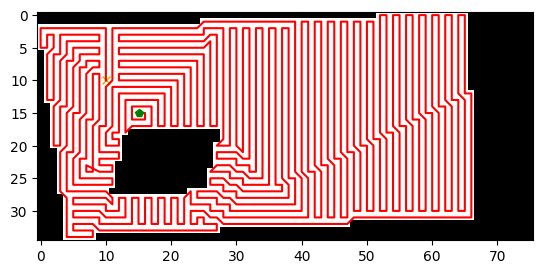

backtracing to (26, 26)


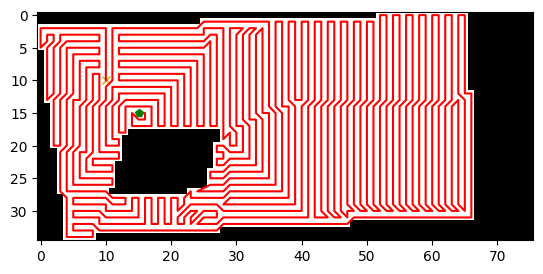

[(10, 10), (9, 10), (8, 10), (7, 10), (6, 10), (5, 10), (4, 10), (3, 10), (2, 10), (2, 9), (2, 8), (2, 7), (2, 6), (2, 5), (2, 4), (2, 3), (2, 2), (2, 1), (2, 0), (3, 0), (4, 0), (5, 0), (5, 1), (4, 1), (3, 1), (3, 2), (4, 2), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (13, 2), (12, 2), (11, 2), (10, 2), (9, 2), (8, 2), (7, 2), (6, 2), (6, 3), (5, 3), (4, 3), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (4, 9), (4, 8), (4, 7), (4, 6), (4, 5), (4, 4), (5, 4), (6, 4), (7, 3), (8, 3), (9, 3), (10, 3), (11, 3), (12, 3), (13, 3), (14, 2), (15, 2), (16, 2), (17, 2), (18, 2), (19, 2), (20, 2), (20, 3), (19, 3), (18, 3), (17, 3), (16, 3), (15, 3), (14, 3), (14, 4), (13, 4), (12, 4), (11, 4), (10, 4), (9, 4), (8, 4), (7, 4), (7, 5), (6, 5), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (6, 9), (6, 8), (6, 7), (6, 6), (7, 6), (8, 5), (9, 5), (10, 5), (11, 5), (12, 5), (13, 5), (14, 5), (15, 4), (16, 4), (17, 4), (18, 4), (19, 4), (20, 4), (21, 3), (22, 3), (

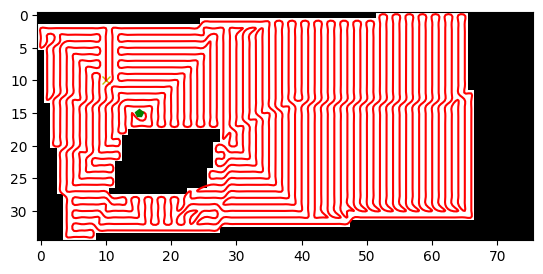

In [74]:
import geopandas as gpd
from shapely.geometry import Polygon
import folium

import numpy as np
from shapely.geometry import Point, box

import matplotlib.pyplot as plt
import matplotlib as mpl
import geopy.distance
import math


def translate_latlong(reference_point,lat_translation_meters,long_translation_meters):
    """ method to move any lat,long point by provided meters in lat and long direction.
    params :
        reference point: longitude and latitude tuple in degrees as decimal values, e.g. 37.43609517497065, -122.17226450150885
        lat_translation_meters: movement of point in meters in lattitude direction.
                                positive value: up move, negative value: down move
        long_translation_meters: movement of point in meters in longitude direction.
                                positive value: left move, negative value: right move
    
    https://stackoverflow.com/questions/7477003/calculating-new-longitude-latitude-from-old-n-meters
    answer: https://stackoverflow.com/a/69713865
    """

    lat_reference = reference_point[1]
    long_reference = reference_point[0]

    earth_radius = 6378.137
    # 1 meter as a degree
    meter_as_degree = (1 / ((2 * math.pi / 360) * earth_radius)) / 1000
    
    #Calculate top, which is lat_translation_meters above
    lat_new = lat_reference + (lat_translation_meters * meter_as_degree)

    #Calculate right, which is long_translation_meters right
    long_new = long_reference + (long_translation_meters * meter_as_degree) / math.cos(lat_reference * (math.pi / 180))
    
    return lat_new,long_new


def calculateDistanceInMeters(start, end):
    """
    calculates the distance between 2 points in meters
    """
    
    # swaps coords from x,y (longitude, latitude) to y,x (latitude, longitude) as that is what geopy uses
    def swap(coords):
        return (coords[1], coords[0])

    return geopy.distance.geodesic(swap(start), swap(end)).m

def convertPathToPolyLine(ref_point, path, cell_size=1.0):
    """
    converts the generated path to a list of lon, lat coordinate pairs based on the cell size
    ref_point : the top left point of the bounding box
    path : the generated path
    cell_size : the size of 1 cell unit. should be the same as the size used when generating the path. defaults to 1.0
    """
    points = []
    for x,y in path:
        lat, lon = translate_latlong(ref_point, x*cell_size, y*cell_size)
        points.append((lat,lon))
    
    return points







def createGrid(polygon, ref_point, width, height, cell_size=1.0):
    """
    polygon : the mowable area polygon, obstacles should be subtracted out using shapely difference function
    ref_point : the top left point of the bounding box
    width: width of bounding box (meters)
    height: height of bounding box (meters)
    cell_size : size of the cell in meters, defaults to 1 cell = 1m. this is used to calculate how accurate the resulting grid is
    returns a binary grid of size width*height

    """
    
    # rounded width and height values
    width_rnd = round(width / cell_size)
    height_rnd = round(height / cell_size)

    
    grid = np.ones((width_rnd, height_rnd), dtype=np.uint8)
    for i in range(width_rnd):
        for j in range(height_rnd):
            # add 0.5 to shift to center of cell rather then top left corner
            cell_center_x = cell_size * (i + 0.5)
            cell_center_y = cell_size * (j + 0.5)
            lon, lat = translate_latlong(ref_point, cell_center_x, cell_center_y)
            # print(f"lat = {lat}, lon = {lon}") # DEBUG
            point = Point(lat, lon)
            if point.within(polygon):
                # print(f"point {point} is within mowable area polygon") # DEBUG
                grid[i][j] = 0
            

    return grid


"""
from the bounding box calculate the distance in meters from the coordinate pairs
create a numpy grid with each cell representing 1m or 50cm maybe?
apply polygon mask to grid

the mask should apply 1 for obstacle or outside bounds and 0 for empty space

then run the wavefront algorithm on the grid
convert the path into coordinate points based on the unit chosen for the grid
use the top left bounding box point as reference = bounding_box_vertices[0]

based on the cell index calculate the latitude,longitude offset from the top left bounding box coords

eg. 
0,0 = top left coordinate
0,1 = the coordinate 1 unit offset
10,10 = the 10 unit offset in longitude and 10 unit offset in latitude

"""


# todo : read from file
mowable_area_vertices = [(146.0258488206752,-38.17203793044747), (146.0261513349644,-38.17204650059956), (146.0261552443641,-38.17193322668973), (146.025868731972,-38.17192171441418), (146.0258488206752,-38.17203793044747)]

# todo : read from file
obstacle_vertices = [
    [(146.0259118061441,-38.1719811607882), (146.0259764416978,-38.17198081525819), (146.0259654347489,-38.17194807541533), (146.0258996113492,-38.17194562358967), (146.0259118061441,-38.1719811607882)]
]

cell_resolution = 0.4 # 10cm grid cell size

# the geometry of the mowable area as a shapely polygon
mowable_area_geom = Polygon(mowable_area_vertices)
# mowable_area_polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[mowable_area_geom])   

print(f"mowable_area_geom bounds = {mowable_area_geom.exterior.bounds}")


# rectangle = x1 y1, x1 y2, x2 y2, x2 y1)
minx,miny,maxx,maxy = mowable_area_geom.exterior.bounds

# longitude latitude order bounding box
bounding_box_vertices = [
    # top left, top right
    (minx,miny), (minx,maxy), 
    # bottom left, bottom right
    (maxx,maxy), (maxx,miny)
]

bounding_geom = Polygon(bounding_box_vertices)

bounding_polygon = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[bounding_geom])   

# removes obstacles from the polygons geometry
for obstacle in obstacle_vertices:
    mowable_area_geom = mowable_area_geom.difference(Polygon(obstacle))

# calculate width and height of bounding box
bounding_box_width = calculateDistanceInMeters(bounding_box_vertices[0], bounding_box_vertices[1])
bounding_box_height = calculateDistanceInMeters(bounding_box_vertices[0], bounding_box_vertices[2])

grid = createGrid(mowable_area_geom, bounding_box_vertices[0], bounding_box_width, bounding_box_height, cell_size=cell_resolution)

# flip grid vertically
# grid = np.flip(grid, 0) # remove

start = (10,10)
goal = (15,15)



polygon_mask = grid

# distance transform wavefront
DT = wavefront_transform(polygon_mask, goal, transform_type='distance')
DT_path = wavefront(DT, start, goal)
visualize_path(polygon_mask, start, goal, DT_path)

PT = wavefront_transform(polygon_mask, goal, transform_type='path', alpha=0.01)
PT_path = wavefront(PT, start, goal)
visualize_path(polygon_mask, start, goal, PT_path)

print(DT_path)
print(PT_path)

pt_path_coords = convertPathToPolyLine(bounding_box_vertices[0], PT_path, cell_size=cell_resolution)

spline = calculateSpline2d(PT_path, cell_size=cell_resolution)
spline = list(spline)

visualize_path(polygon_mask, start, goal, spline)

spline_path_coords = convertPathToPolyLine(bounding_box_vertices[0], spline, cell_size=cell_resolution)
#
#
#

#
# show polygons on folium map
#

# get center of boundary. this is to center folium map
centerLat, centerLon = bounding_geom.centroid.coords[0]


boundary_map = folium.Map([centerLon, centerLat], zoom_start=100, max_zoom=22)
folium.GeoJson(mowable_area_geom, name='mowable area').add_to(boundary_map)
folium.GeoJson(bounding_polygon, name='bounds').add_to(boundary_map)

# print(pt_path_coords)
# folium.PolyLine(pt_path_coords).add_to(boundary_map)
folium.PolyLine(spline_path_coords).add_to(boundary_map)

# folium.Marker([centerLat, centerLon], tooltip='center of bounding box').add_to(boundary_map)

obstacleStyle = {'fillColor': '#228B22', 'color': '#228B22'}
for obstacle in obstacle_vertices:
    obstacle_geom = Polygon(obstacle)
    obstaclePoly = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[obstacle_geom])   
    folium.GeoJson(obstaclePoly, name='obstacle', style_function=lambda x:obstacleStyle).add_to(boundary_map)

folium.LatLngPopup().add_to(boundary_map)
folium.LayerControl().add_to(boundary_map)

boundary_map # uncomment to see path plotted on map

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


# Define grid size and cell resolution
grid_size = 100
cell_resolution = 0.1

# Define polygon vertices
polygon_vertices = [(0, 0), (50, 0), (50, 30), (30, 30), (30, 20), (0, 20)]
# polygon_vertices = [(146.0258488206752,-38.17203793044747), (146.0261513349644,-38.17204650059956), (146.0261552443641,-38.17193322668973), (146.025868731972,-38.17192171441418), (146.0258488206752,-38.17203793044747)]
# polygon_vertices = [(-38.17203793044747, 146.0258488206752)]

# swapped_vertices = []
# for v in polygon_vertices:
#     swapped_vertices.append((v[1], v[0]))


# coords = latlon_to_xy(swapped_vertices)

# a list of lists, each list contains the vertices for the obstacle
obstacle_vertices = [
    [(45,10), (5,25), (45,25)],
]

# Create occupancy grid
occupancy_grid = np.zeros((grid_size, grid_size), dtype=np.uint8)

# Create polygon mask
polygon_mask = np.zeros((grid_size, grid_size), dtype=np.uint8)
pts = np.array(polygon_vertices, np.int32)
pts = pts.reshape((-1,1,2))
cv2.fillPoly(polygon_mask, [pts], 255)

for obstacle in obstacle_vertices:
    obstacle_mask = np.zeros((grid_size, grid_size), dtype=np.uint8)
    pts = np.array(obstacle, np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.fillPoly(obstacle_mask, [pts], 255)
    # subtract the obstacle mask from the polygon mask
    cv2.subtract(polygon_mask, obstacle_mask, polygon_mask)


# Convert polygon mask to occupancy grid
for i in range(grid_size):
  for j in range(grid_size):
    if polygon_mask[i][j] > 0:
      occupancy_grid[i][j] = 1


plotBinary(polygon_mask)

# print(polygon_mask)
# print(occupancy_grid)

# plotBinary(polygon_mask)

start = (0, 0)
goal = (2,1)

# invert the polygon mask
polygon_mask = cv2.bitwise_not(polygon_mask)

# distance transform wavefront
DT = wavefront_transform(polygon_mask, goal, transform_type='distance')
DT_path = wavefront(DT, start, goal)
print(DT_path)
visualize_path(polygon_mask, start, goal, DT_path)

PT = wavefront_transform(polygon_mask, goal, transform_type='path', alpha=0.01)
PT_path = wavefront(PT, start, goal)
visualize_path(polygon_mask, start, goal, PT_path)


